```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc


#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting


In [3]:
%cuda_context_handler gpu_ctx

# Select area and result folder

In [4]:
#Set this to false before comitting to only get images
create_movie = False
movie_frames = 200
download_data = True
timestep_indices = None


# How many cells to erode of land
erode_land=1

case_name = 'complete_coast'

out_folder = os.path.join(datetime.date.today().isoformat(), case_name)

os.makedirs(out_folder, exist_ok=True)
print("Output will be placed in '" + out_folder + "'")

Output will be placed in '2019-11-18/complete_coast'


# Inspect URL and select area

In [5]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

# Run original resolution simulation

In [6]:
# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0,
    "write_netcdf": True,
    "model_time_step": 60
}

In [7]:
data_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url, case_name,
                                                                  timestep_indices=timestep_indices,
                                                                  erode_land=erode_land)


In [13]:

if 'sim' in globals():
    sim.cleanUp()



original_filename = os.path.join(out_folder, case_name + "_original.nc")
print(original_filename)


importlib.reload(CDKLM16)
importlib.reload(Observation)
sim = CDKLM16.CDKLM16(**sim_args, 
                      **NetCDFInitialization.removeMetadata(data_args),
                      netcdf_filename=original_filename)

drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, 10,
                                                     domain_size_x=sim.nx*sim.dx,
                                                     domain_size_y=sim.ny*sim.dy)

# Some hard coded positions that are not on land
drifter_positions=np.array([[ 50, 200],
                            [110, 200],
                            [170, 200],
                            [230, 200],
                            [290, 200],
                            [350, 200],
                            [ 50, 110],
                            [110, 110],
                            [170, 110],
                            [290, 115],
                           ], dtype=np.float32)
drifters.setDrifterPositions(drifter_positions*1000)

sim.attachDrifters(drifters)

#--------------------------------------------------------------
# Create observation object and write the first drifter positions
#--------------------------------------------------------------
observations = Observation.Observation(domain_size_x = sim.nx*sim.dx,
                                       domain_size_y = sim.ny*sim.dy,
                                       nx=sim.nx, ny=sim.ny,
                                       land_mask=sim.getLandMask())


                                       
# Configure observations to register observations from static positions
# according to equi-distant griding (every 25 cells) 
# Land mask is used to filter out dry cells.
#observations.setBuoyCellsByFrequency(50, 50, avoid_boundary=True)
buoy_positions = np.array([[1200, 700]])
observations.setBuoyCells(buoy_positions)

# Register observation at the start of the simulation
# This includes drifters if sim has drifters, and grid cells as defined above
observations.add_observation_from_sim(sim)




Closing file 2019-11-18/complete_coast/complete_coast_original.nc ...
2019-11-18/complete_coast/complete_coast_original.nc


In [14]:
print(sim.ny, sim.nx)
print(observations.land_mask.shape)
245*0.8

846 2546
(846, 2546)


196.0

True False


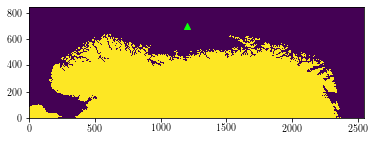

In [15]:

plt.imshow(observations.land_mask, origin='lower')
print(observations.land_mask[40, 400], observations.land_mask[250, 10])
plt.scatter(x=observations.buoy_indices[:,0], 
            y=observations.buoy_indices[:,1],
            color='xkcd:neon green', marker='^')

In [16]:
def run_sim(sim, observations, sampling_frequency):
    
    if sim.t >= 23*60*60:
        print('simulator is already done')
        return
    

    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0), display_id=True)
    
    end_t = 23*60*60
    netcdf_frequency = 60*60
    
    netcdf_iterations = np.int(end_t/netcdf_frequency)
    sampling_iterations = np.int(netcdf_frequency/sampling_frequency)
    print('running ' + str(netcdf_iterations) + ' netcdf_iterations')
    print('   with ' + str(sampling_iterations) + ' sampling_iterations')
    total_number_of_iterations = netcdf_iterations*sampling_iterations
    
    
    i = 0
    for netcdf_i in range(netcdf_iterations):
        
        for sampling_i in range(sampling_iterations):
            
            write_now = (sampling_i == sampling_iterations-1)
        
        
            sim.dataAssimilationStep(sim.t + sampling_frequency,
                                     write_now=write_now)
            
            observations.add_observation_from_sim(sim)

            pp.update(progress.getPrintString(i/(total_number_of_iterations-1)))
            i += 1
    sim.closeNetCDF()
    
    
    ## Dump to pickle
    
run_sim(sim, observations, 5*60)

#store observation file
observation_filename = 'observation_'+datetime.datetime.now().strftime("%H_%M_%S")+'.pickle'
observations.to_pickle(os.path.join(out_folder, observation_filename))



'0% [##############################] 100%. Total: 4m 6s, elapsed: 4m 6s, remaining: 0s'

running 23 netcdf_iterations
   with 12 sampling_iterations
Closing file 2019-11-18/complete_coast/complete_coast_original.nc ...


In [ ]:
importlib.reload(norkyst_plotting)

norkyst_plotting.ncAnimation(original_filename,
             title="original $t_0$=" + datetime.datetime.fromtimestamp(data_args['t0']).isoformat(timespec='seconds'),
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,10)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=1,
             rotate=True, 
             downsample=2,
             drifter_locations=drifters.getDrifterPositions(),
             drifter_locations_original=drifter_positions*1000,
             buoy_indices=observations.buoy_indices.copy())

# Read observation file and plot some results

In [ ]:
obs = Observation.Observation(observation_type=dautils.ObservationType.StaticBuoys,
                              domain_size_x=sim.nx*sim.dx, domain_size_y=sim.ny*sim.dx,
                              nx=sim.nx, ny=sim.ny,
                              land_mask=sim.getLandMask())
obs.read_pickle(os.path.join(out_folder, observation_filename))

In [ ]:
num_drifters = obs.get_num_drifters(ignoreBuoys=True)
print('num drifters (ignoring buoys)', num_drifters)
drifter_paths = [None]*num_drifters
for i in range(num_drifters):
    drifter_paths[i] = obs.get_drifter_path(i, 0, 23*60*60)

In [ ]:
def forecastPlot(ax, true_paths, ensemble_paths, color_id=0, 
                 forecast_point_size=2, truth_point_size=6, mean_paths=[None]):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:viridian', 'xkcd:foam green']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]
    mean_color = color_combinations[color_id][2]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color, alpha=0.3)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                      forecast_point_size, 
                                                      fill=False, zorder=10,
                                                      alpha=0.7)
        ax.add_patch(circ_end_forecast)

    
    # Plot true path
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)
    
    # Plot mean path
    if mean_paths[0] is not None:
        for path in mean_paths:
            ax.plot(path[:,0], path[:,1], color=mean_color, zorder=6)
    
    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           truth_point_size,
                                           fill=False, zorder=10)
    ax.add_patch(circ_start)
    #circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
    #                                     truth_point_size,
    #                                     fill=False, zorder=10)
    #ax.add_patch(circ_end)
    ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    # Mark end of mean path
    if mean_paths[0] is not None:
        #xend = matplotlib.patches.Circle((mean_paths[-1][-1,0], mean_paths[-1][-1,1]),
        #                                 truth_point_size,
        #                                 fill=False, zorder=10)
        #ax.add_patch(xend)
        ax.plot(mean_paths[-1][-1,0], mean_paths[-1][-1,1], 
                   marker='o', markeredgecolor='k', markerfacecolor=None)
        
def createForecastCanvas(observation):
    """
    true_sim_reader: The SimReader object containing nx, ny, etc
    """   
    
    nx = observation.nx
    ny = observation.ny
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    
    extent=np.array([0, observation.domain_size_x, 0, observation.domain_size_y])/1000
    ax.imshow(observation.land_mask, origin="lower", 
              extent=extent, cmap='binary')

    return ax

ax = createForecastCanvas(obs)
for drifter_path in drifter_paths:
    forecastPlot(ax, drifter_path, [], truth_point_size=1)
    


In [ ]:
buoy_id = 35

def get_time_series_for_buoy(observation, buoy_id):
    
    time  = observation.obs_df[observation.time_key].to_numpy()
    hu = np.empty_like(time)
    hv = np.empty_like(time)
    
    all_buoy_obs = observation.obs_df[observation.buoy_observations_key]
    for t in range(len(time)):
        hu[t] = all_buoy_obs[t][buoy_id,0]
        hv[t] = all_buoy_obs[t][buoy_id,1]

    return time, hu, hv

t, hu, hv = get_time_series_for_buoy(obs, buoy_id)

print(t.shape)
print(type(hu), hu.shape)

fig = plt.figure(figsize=(8,4))
plt.plot(t, hu, label='hu')
plt.plot(t, hv, label='hv')
plt.legend()
plt.title('')